In [2]:
from pyspark.sql import SparkSession

# Create a spark session (which will run spark jobs)
spark = (
    SparkSession.builder.appName("MAST30034_Yellow_Taxi_Inspection")
    .config("spark.sql.repl.eagerEval.enabled", True)
    .config("spark.sql.parquet.cacheMetadata", "true")
    .config("spark.executor.memory", "2g")
    .config("spark.driver.memory", "4g")
    .getOrCreate()
)

22/08/17 10:57:36 WARN Utils: Your hostname, DESKTOP-85B961I resolves to a loopback address: 127.0.1.1; using 172.17.43.244 instead (on interface eth0)
22/08/17 10:57:36 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


22/08/17 10:57:39 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [3]:
sdf = spark.read.parquet('../data/curated/yellow_taxi_cleaned_subsampled.parquet')

In [ ]:
sdf.printSchema()

In [6]:
from pyspark.sql import functions as F

In [ ]:
timestamp_features = {"tpep_pickup_datetime", "tpep_dropoff_datetime"}
datetime_features = {"PU_datetime", "DO_datetime"}
stems = {"weekday", "month", "weekday_num", "month_num"}

In [7]:
# Cast timestamp for time features to datetime type
sdf = sdf.withColumn("PU_datetime",
              F.to_date("tpep_pickup_datetime"))

sdf = sdf.withColumn("DO_datetime",
              F.to_date("tpep_dropoff_datetime"))

In [8]:
# feature engineering : day of week
sdf = sdf.withColumn("PU_dayofweek",
                     F.dayofweek("PU_datetime"))

sdf = sdf.withColumn("DO_dayofweek",
                     F.dayofweek("DO_datetime"))

In [9]:
# feature engineering : day of month
sdf = sdf.withColumn("PU_dayofmonth",
                     F.dayofmonth("PU_datetime"))

sdf = sdf.withColumn("DO_dayofweek",
                     F.dayofmonth("DO_datetime"))

In [10]:
# feature engineering : month of year
sdf = sdf.withColumn("PU_month",
                     F.month("PU_datetime"))

sdf = sdf.withColumn("DO_month",
                     F.month("DO_datetime"))

In [11]:
# feature engineering : trip_time in seconds
sdf = sdf.withColumn("trip_time_seconds",
                     F.col("tpep_dropoff_datetime").cast("long") - F.col("tpep_pickup_datetime").cast("long"))

In [12]:
# feature engineering : trip_time in minutes
sdf = sdf.withColumn("trip_time_minutes",
                     (F.col("tpep_dropoff_datetime").cast("long") - F.col("tpep_pickup_datetime").cast("long")) / 60)

In [13]:
# feature engineering : speed mph
sdf = sdf.withColumn("trip_speed_mph",
                     (F.col("trip_distance") / (F.col("trip_time_minutes")/60)))

In [14]:
# feature engineering : fare_amount / minute
sdf = sdf.withColumn("fare_per_minute",
                     (F.col("fare_amount")) / (F.col("trip_time_minutes")))

In [15]:
sdf.printSchema()
sdf.limit(5)

root
 |-- VendorID: integer (nullable = true)
 |-- tpep_pickup_datetime: timestamp (nullable = true)
 |-- tpep_dropoff_datetime: timestamp (nullable = true)
 |-- passenger_count: double (nullable = true)
 |-- trip_distance: double (nullable = true)
 |-- RatecodeID: integer (nullable = true)
 |-- store_and_fwd_flag: boolean (nullable = true)
 |-- PULocationID: integer (nullable = true)
 |-- DOLocationID: integer (nullable = true)
 |-- payment_type: integer (nullable = true)
 |-- fare_amount: double (nullable = true)
 |-- extra: double (nullable = true)
 |-- mta_tax: double (nullable = true)
 |-- tip_amount: double (nullable = true)
 |-- tolls_amount: double (nullable = true)
 |-- improvement_surcharge: double (nullable = true)
 |-- total_amount: double (nullable = true)
 |-- congestion_surcharge: double (nullable = true)
 |-- airport_fee: integer (nullable = true)
 |-- is_valid_record: boolean (nullable = true)
 |-- PU_datetime: date (nullable = true)
 |-- DO_datetime: date (nullable = 

VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee,is_valid_record,PU_datetime,DO_datetime,PU_dayofweek,DO_dayofweek,PU_dayofmonth,PU_month,DO_month,trip_time_seconds,trip_time_minutes,trip_speed_mph,fare_per_minute
1,2019-03-01 11:05:21,2019-03-01 11:38:23,1.0,14.1,1,false,249,28,1,41.0,3.0,0.5,10.1,5.76,0.3,60.66,2.5,null,true,2019-03-01,2019-03-01,6,1,1,3,3,1982,33.03333333333333,25.610494450050453,1.24117053481332
2,2019-03-01 11:19:09,2019-03-01 11:23:30,1.0,0.71,1,false,137,234,1,5.0,0.5,0.5,1.0,0.0,0.3,9.8,2.5,null,true,2019-03-01,2019-03-01,6,1,1,3,3,261,4.35,9.793103448275863,1.149425287356322
2,2019-03-01 11:55:49,2019-03-01 12:11:06,1.0,5.97,1,false,152,153,2,19.0,0.5,0.5,0.0,0.0,0.3,20.3,0.0,null,true,2019-03-01,2019-03-01,6,1,1,3,3,917,15.283333333333333,23.43729552889858,1.243184296619411
2,2019-03-01 11:13:43,2019-03-01 11:21:39,2.0,1.67,1,false,107,161,1,8.0,0.5,0.5,2.36,0.0,0.3,14.16,2.5,null,true,2019-03-01,2019-03-01,6,1,1,3,3,476,7.933333333333334,12.630252100840336,1.0084033613445378
1,2019-03-01 11:27:35,2019-03-01 11:50:42,1.0,9.9,1,false,132,177,1,29.0,0.5,0.5,6.05,0.0,0.3,36.35,0.0,null,true,2019-03-01,2019-03-01,6,1,1,3,3,1387,23.116666666666667,25.6957462148522,1.254506128334535


In [61]:
# Plotting speeds
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd

Univariate Analysis

In [ ]:
df = sdf.toPandas()

Trip time

In [ ]:
sns.boxplot(df['trip_time_minutes'])

In [ ]:
# export to pandas df
log_trip_speed_mpg = np.log(sdf.select('trip_speed_mph').toPandas())

<AxesSubplot:xlabel='trip_speed_mph', ylabel='Density'>

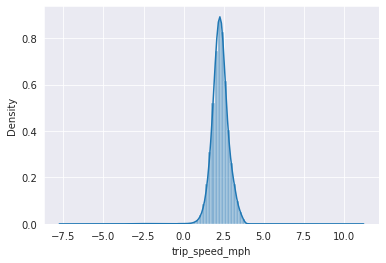

In [56]:
sns.histplot(x=log_trip_speed_mpg['trip_speed_mph'], bins=100, kde=True, stat='density')


<AxesSubplot:xlabel='trip_speed_mph'>

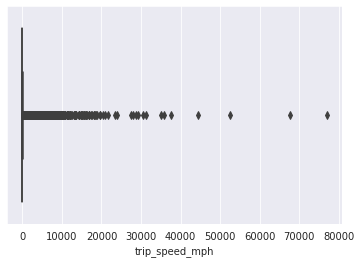

In [58]:
sns.boxplot(x=np.exp(log_trip_speed_mpg['trip_speed_mph']))

In [65]:
df = pd.DataFrame(np.exp(log_trip_speed_mpg['trip_speed_mph']))


In [66]:
df.sort_values(by='trip_speed_mph')

,trip_speed_mph
5287990,0.000426
6977780,0.000431
969934,0.000450
2919053,0.000484
3818887,0.000517
...,...
7496942,NaN
7577071,NaN
7633644,NaN
7635752,NaN


* Found NaN values -> time taken > 0 #Todo: time taken > 0

<AxesSubplot:xlabel='trip_speed_mph'>

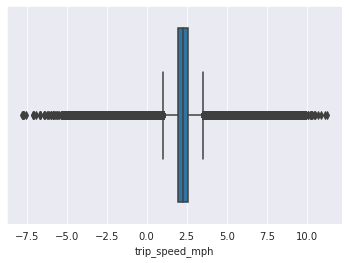

In [79]:
len(df[df['trip_speed_mph'] >= 104])
len(df[df['trip_speed_mph'] <= 0.3])

#sns.boxplot(x=df[df['trip_speed_mph'] >= 104])



sns.boxplot(x=log_trip_speed_mpg['trip_speed_mph'])

# remove these values...

In [ ]:
# summary statistic of the log transformed variables
